In [1]:
import numpy as np
import gymnasium as gym
import torch

from tensoraerospace.envs.f16.linear_longitudial import LinearLongitudinalF16
from tensoraerospace.utils import generate_time_period, convert_tp_to_sec_tp
from tensoraerospace.signals.standart import unit_step, sinusoid
from tensoraerospace.benchmark.function import static_error
from tensoraerospace.agent.mpc.stochastic import Net
from tensoraerospace.agent.mpc.gradient import MPCOptimizationAgent
from tensoraerospace.signals.random import full_random_signal


In [2]:
# Инициализация списка для хранения исторических данных
hist = []
dt = 0.1  # Интервал дискретизации времени

# Генерация временного периода с заданным интервалом дискретизации
tp = generate_time_period(tn=180, dt=dt) 

# Конвертация временного периода в секунды
tps = convert_tp_to_sec_tp(tp, dt=dt)

# Вычисление общего количества временных шагов
number_time_steps = len(tp) 

# Создание заданного сигнала с использованием единичного шага
# reference_signals = np.reshape(unit_step(degree=0, tp=tp, time_step=20, output_rad=True), [1, -1])
reference_signals = np.reshape(np.deg2rad(sinusoid(amplitude=0.004, tp=tp, frequency=1)), [1, -1])

# Создание среды симуляции, задание временных шагов, начального состояния, заданного сигнала и отслеживаемых состояний
env = gym.make('LinearLongitudinalF16-v0',
                number_time_steps=number_time_steps, 
                initial_state=[[0],[0],[0],[0],[0]],
                reference_signal=reference_signals,
                state_space = [ "theta", "alpha", "q", "altitude", "velocity"],
                output_space = ["theta", "alpha", "q", "altitude", "velocity"],
                tracking_states=["alpha"], use_reward = False)

# Сброс среды к начальному состоянию
state, info = env.reset()

/Users/asmazaev/Projects/TensorAeroSpace/.venv/lib/python3.11/site-packages/gymnasium/utils/passive_env_checker.py:159: UserWarning: WARN: The obs returned by the `reset()` method is not within the observation space.
  logger.warn(f"{pre} is not within the observation space.")


In [3]:
model = Net(env.action_space.shape[0], env.observation_space.shape[0])

In [4]:
def cost(next_state, action, reference_signals, step):
    # Извлечение состояния системы
    theta,alpha, omega_z = np.rad2deg(next_state[0].detach().numpy())
    
    # Получение эталонного сигнала на данном шаге
    alpha_ref = np.rad2deg(reference_signals[0][step])
    
    # Расчёт ошибки тангажа
    pitch_error = (alpha - alpha_ref) ** 2
        
    return (pitch_error ** 2 + 0.1 * omega_z ** 2 + 0.0001 * (action ** 2))
# agent.cost_function = cost

In [5]:
agent = MPCOptimizationAgent(gamma=0.99, action_dim=1, observation_dim=2, model=model, cost_function=cost, env=env, lr=1e-5, criterion=torch.nn.MSELoss())

In [6]:
from tqdm import tqdm

# Создаем исследовательские сигналы для обучения модели

exploration_signals = [
    np.reshape(np.deg2rad(sinusoid(amplitude=0.01, tp=tp, frequency=5)), [1, -1]), 
    np.reshape(np.deg2rad(sinusoid(amplitude=0.03, tp=tp, frequency=5)), [1, -1]), 
    np.reshape(np.deg2rad(sinusoid(amplitude=-0.03, tp=tp, frequency=5)), [1, -1]),
    np.reshape(np.deg2rad(sinusoid(amplitude=0.03, tp=tp, frequency=10)), [1, -1]), 
    np.reshape(np.deg2rad(sinusoid(amplitude=-0.03, tp=tp, frequency=10)), [1, -1]), 
    np.reshape(np.deg2rad(sinusoid(amplitude=0.01, tp=tp, frequency=10)), [1, -1]), 
    np.reshape(np.deg2rad(sinusoid(amplitude=-0.01, tp=tp, frequency=10)), [1, -1]), 
    np.reshape(np.deg2rad(sinusoid(amplitude=0.01, tp=tp, frequency=1)), [1, -1]), 
    np.reshape(np.deg2rad(sinusoid(amplitude=-0.01, tp=tp, frequency=1)), [1, -1]), 
    np.reshape(np.deg2rad(sinusoid(amplitude=-0.01, tp=tp, frequency=25)), [1, -1]), 
    np.reshape(np.deg2rad(sinusoid(amplitude=0.01, tp=tp, frequency=25)), [1, -1]), 
    np.reshape(np.deg2rad(sinusoid(amplitude=0.02, tp=tp, frequency=5)), [1, -1]), 

    np.reshape(np.deg2rad(sinusoid(amplitude=0.004, tp=tp, frequency=1)), [1, -1]), 
    np.reshape(np.deg2rad(sinusoid(amplitude=-0.004, tp=tp, frequency=1)), [1, -1]), 
    np.reshape(np.deg2rad(sinusoid(amplitude=-0.008, tp=tp, frequency=1)), [1, -1]),
    np.reshape(np.deg2rad(sinusoid(amplitude=0.008, tp=tp, frequency=1)), [1, -1]),
    np.reshape(np.deg2rad(sinusoid(amplitude=-0.009, tp=tp, frequency=1)), [1, -1]),
    np.reshape(np.deg2rad(sinusoid(amplitude=0.009, tp=tp, frequency=1)), [1, -1]),
    np.reshape(np.deg2rad(sinusoid(amplitude=0.005, tp=tp, frequency=1)), [1, -1]),
    np.reshape(np.deg2rad(sinusoid(amplitude=-0.005, tp=tp, frequency=1)), [1, -1]),
    np.reshape(np.deg2rad(sinusoid(amplitude=0.01, tp=tp, frequency=1)), [1, -1]), 
    np.reshape(np.deg2rad(sinusoid(amplitude=-0.01, tp=tp, frequency=1)), [1, -1]), 
    
    np.reshape(np.deg2rad(sinusoid(amplitude=0.0089, tp=tp, frequency=25)), [1, -1]), 
    np.reshape(np.deg2rad(sinusoid(amplitude=-0.0089, tp=tp, frequency=25)), [1, -1]),
    np.reshape(np.deg2rad(sinusoid(amplitude=0.008, tp=tp, frequency=25)), [1, -1]),
    np.reshape(np.deg2rad(sinusoid(amplitude=-0.008, tp=tp, frequency=25)), [1, -1]),
    np.reshape(np.deg2rad(sinusoid(amplitude=-0.004, tp=tp, frequency=25)), [1, -1]),
    np.reshape(np.deg2rad(sinusoid(amplitude=0.004, tp=tp, frequency=25)), [1, -1]),
    np.reshape(np.deg2rad(sinusoid(amplitude=0.009, tp=tp, frequency=25)), [1, -1]),
    np.reshape(np.deg2rad(sinusoid(amplitude=-0.009, tp=tp, frequency=25)), [1, -1]),
    
    np.reshape(np.deg2rad(sinusoid(amplitude=0.0085, tp=tp, frequency=25)), [1, -1]),
    np.reshape(np.deg2rad(sinusoid(amplitude=-0.0085, tp=tp, frequency=25)), [1, -1]),


    np.reshape(np.deg2rad(sinusoid(amplitude=0.04, tp=tp, frequency=1)), [1, -1]), 

    np.reshape(np.deg2rad(sinusoid(amplitude=0, tp=tp, frequency=0)), [1, -1]),
    np.reshape(np.deg2rad(sinusoid(amplitude=0, tp=tp, frequency=0)), [1, -1]),
    np.reshape(np.deg2rad(sinusoid(amplitude=0.004, tp=tp, frequency=25)), [1, -1]),
    np.reshape(np.deg2rad(sinusoid(amplitude=0.005, tp=tp, frequency=25)), [1, -1]),
    np.reshape(np.deg2rad(unit_step(degree=12, tp=tp, time_step=12)), [1, -1]),
    [None],[None],[None],
]
states = np.array([[0.,    0.,    0.,    0.,    0.]])
actions = np.array([0])
next_states = np.array([[0.,   0.,    0.,    0.,    0.]])
np.random.shuffle(exploration_signals)

for ref_signal in tqdm(exploration_signals):
    sin_states, sin_actions, sin_next_states = agent.collect_data(num_episodes=40, control_exploration_signal=ref_signal[0])
    states = np.append(states, sin_states, 0)
    actions = np.append(actions, sin_actions, 0)
    next_states = np.append(next_states, sin_next_states, 0)

  0%|          | 0/41 [00:00<?, ?it/s]/Users/asmazaev/Projects/TensorAeroSpace/.venv/lib/python3.11/site-packages/gymnasium/utils/passive_env_checker.py:135: UserWarning: WARN: The obs returned by the `step()` method was expecting numpy array dtype to be float32, actual type: float64
  logger.warn(
/Users/asmazaev/Projects/TensorAeroSpace/.venv/lib/python3.11/site-packages/gymnasium/utils/passive_env_checker.py:159: UserWarning: WARN: The obs returned by the `step()` method is not within the observation space.
  logger.warn(f"{pre} is not within the observation space.")
100%|██████████| 41/41 [00:55<00:00,  1.35s/it]


In [7]:
agent.train_model(states, actions, next_states, epochs=5, batch_size=64)

Loss 2.3983698156371247e-06: 100%|██████████| 5/5 [03:04<00:00, 36.95s/it]


In [8]:
states, actions, next_states = agent.collect_data(num_episodes=10,
            control_exploration_signal=np.reshape(full_random_signal(0,0.1,180, (-0.5, 0.5), (-5, 5)), [1, -1])[0])

100%|██████████| 10/10 [00:00<00:00, 24.94it/s]


In [9]:
agent.test_network(states, actions, next_states)

Test MSE Loss: 0.028573382645845413


In [10]:
agent.optimization_lr = 1

In [11]:
def exploration_noise(action, noise_std=0.1, bound=0.1):
    """
    Добавляет шум к действию для исследования пространства действий.

    Args:
        action (torch.Tensor): Входное действие.
        noise_std (float): Стандартное отклонение для гауссовского шума.

    Returns:
        torch.Tensor: Действие с добавленным шумом.
    """
    noise = torch.FloatTensor(action.size()).uniform_(-bound, bound)
    return action + noise

In [12]:
from torch.optim.lr_scheduler import ExponentialLR
from torch.autograd.functional import jacobian

def linearize_system_model(system_model, state, action):
    """
    Linearize the neural network model around a given state and action.

    Args:
        system_model (torch.nn.Module): The neural network model representing the system.
        state (torch.Tensor): The current state of the system.
        action (torch.Tensor): The current action applied to the system.

    Returns:
        A (torch.Tensor): The Jacobian of the system model w.r.t. the state.
        B (torch.Tensor): The Jacobian of the system model w.r.t. the action.
    """
    # Concatenate state and action to create the input tensor for the model
    input_tensor = torch.cat([state, action], dim=-1)
    
    # Compute Jacobian of the system model with respect to the input
    jac = jacobian(system_model, input_tensor)
    
    # Assuming the system_model is of the form f(state, action)
    n_state = state.size(-1)
    n_action = action.size(-1)
    n_output = system_model(input_tensor).size(-1)
    
    # Reshape the Jacobian correctly
    jac = jac.view(n_output, n_state + n_action)
    
    # Extract the Jacobians A and B
    A = jac[:, :n_state]  # Jacobian w.r.t. state
    B = jac[:, n_state:]  # Jacobian w.r.t. action
    
    return A, B

In [13]:
import torch.optim as optim
from torch.optim.lr_scheduler import ExponentialLR

def choose_action_ref(state, rollout, horizon, reference_signals, step, prev_value, optimization_steps, noise_std=0.02):
    """
    Выбирает оптимальное действие с учетом эталонных сигналов.

    Args:
        state (numpy.ndarray): Текущее состояние среды.
        rollout (int): Количество прогнозируемых траекторий для оценки.
        horizon (int): Горизонт планирования.
        reference_signals (numpy.ndarray): Эталонные сигналы для оценки действий.
        step (int): Текущий временной шаг в среде.

    Returns:
        numpy.ndarray: Возвращает массив, содержащий выбранное действие.
    """
    action_smoothing=torch.tensor([[1]])
    action_regularization=0.01
    initial_state = torch.as_tensor(np.array([state]), dtype=torch.float32)
    for _ in range(rollout):
        best_cost = float('inf')
        best_action_sequence = None
        # action_sequence = torch.FloatTensor(horizon, 1).uniform_(-0.43, 0.43)
        # Создание тензора с require_grad=True
        # action_sequence = torch.tensor(action_sequence, requires_grad=True)
        state = initial_state
        action_sequence = torch.FloatTensor(5,1).uniform_(-0.43, 0.43)
        action_sequence = torch.tensor(action_sequence, requires_grad=True)
        optimizer = optim.Adam([action_sequence], lr=agent.optimization_lr, betas=(0.9, 0.999))  # Momentum added via betas
        scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.99)
        costs = []
        actions = []
        # print("action_sequence",action_sequence)
        for h in range(horizon):  # Количество шагов оптимизации
            
    
            for optimization_step in range(optimization_steps):
                
                noisy_action = exploration_noise(action_sequence[h].unsqueeze(0), noise_std=noise_std)
                
                # Linearize the system model around the current state and action
                # A, B = linearize_system_model(agent.system_model, state, noisy_action)
                
                # Predict the next state using the linearized model: next_state = A*state + B*action
                # next_state = torch.matmul(A, state.T).T + torch.matmul(B, noisy_action.T).T

                # print(action_sequence, state)
                # next_state = agent.system_model(torch.cat([state, noisy_action], dim=-1))
                cost = agent.cost_function(next_state, noisy_action, reference_signals, step, prev_value)
                # print(optimizer.param_groups[0]["lr"])
                # total_cost += cost
                # state = next_state
                costs.append(cost)
                actions.append(noisy_action.clone())
                # print(action_sequence)
                if cost < best_cost and cost > 0:
                    best_cost = cost.clone()
                    best_action_sequence = noisy_action.clone()

                cost.backward()
                optimizer.step()
                scheduler.step()
                optimizer.zero_grad()
    # print("best",best_action_sequence[0].detach().numpy())
    # Apply action smoothing
    # if prev_value is not None:
    #     best_action_sequence =  best_action_sequence + action_smoothing * prev_value

    return best_action_sequence, best_cost, costs, actions # Возвращаем первое действие из наилучшей последовательности


In [14]:
def linearize_system_model(state, action):
    """
    Линеаризация модели системы в текущем состоянии и действии.
    Возвращает якобианы по состоянию и действию.

    Args:
        state (torch.Tensor): Текущее состояние системы.
        action (torch.Tensor): Действие.

    Returns:
        (torch.Tensor, torch.Tensor): Якобиан по состоянию и якобиан по действию.
    """
    state_action = torch.cat([state.requires_grad_(True), action.requires_grad_(True)], dim=-1)
    state_action.requires_grad_(True)
    
    # Прогнозируем следующее состояние
    next_state = agent.system_model(state_action)
    
    # Вычисляем градиенты
    jacobian_state = torch.autograd.grad(next_state, state, grad_outputs=torch.ones_like(next_state), retain_graph=True, create_graph=True)[0]
    jacobian_action = torch.autograd.grad(next_state, action, grad_outputs=torch.ones_like(next_state), retain_graph=True, create_graph=True)[0]

    return jacobian_state, jacobian_action


In [15]:
class LocalLinearModel:
    def __init__(self, system_model):
        self.system_model = system_model

    def linearize(self, state, action):
        return linearize_system_model(state, action)

    def predict(self, state, action, initial_state, initial_action):
        jacobian_state, jacobian_action = self.linearize(state, action)
        
        # next_state = state + jacobian_state @ (state - initial_state) + jacobian_action @ (action - initial_action)
        next_state = state + jacobian_state @ (state - initial_state).T + jacobian_action @ (action - initial_action).T
        return next_state

local_model = LocalLinearModel(agent.system_model)


In [16]:
import numpy
import scipy.signal
import scipy.optimize

In [17]:
def objective(control_value, initial_state, reference_signals):
    state = initial_state
    next_state = agent.system_model(torch.cat([state, control_value], dim=-1))
    state = next_state
    return (state[1]-reference_signals)**2

In [36]:
def choose_action_ref(state, rollout, control_horizon, prediction_horizon, reference_trajectory, step, prev_value, optimization_steps, noise_std=0.8):
    """
    Выбирает оптимальное действие для следования опорной траектории.

    Args:
        state (numpy.ndarray): Текущее состояние системы.
        rollout (int): Количество прогнозируемых траекторий для оценки.
        control_horizon (int): Горизонт управления (количество действий, которые может выполнить контроллер).
        prediction_horizon (int): Горизонт прогнозирования (период, в течение которого мы наблюдаем эффект от плана действий).
        reference_trajectory (numpy.ndarray): Опорная траектория, к которой должна стремиться система.
        step (int): Текущий временной шаг в среде.
        prev_value (float): Предыдущее значение действия.
        optimization_steps (int): Количество шагов оптимизации на каждом временном шаге.
        noise_std (float): Стандартное отклонение для добавления шума при исследовании.

    Returns:
        numpy.ndarray: Возвращает массив, содержащий выбранное действие.
    """
    action_smoothing = torch.tensor([[1]])
    action_regularization = 0.01
    initial_state = torch.as_tensor(np.array([state]), dtype=torch.float32)

    best_action_sequence = None
    best_cost = float('inf')

    for _ in range(rollout):
        # Инициализируем последовательность действий
        action_sequence = torch.FloatTensor(control_horizon, 1).uniform_(-0.43, 0.43)
        action_sequence = torch.tensor(action_sequence, requires_grad=True)

        optimizer = optim.RMSprop([action_sequence], lr=agent.optimization_lr)
        scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.99)

        for optimization_step in range(optimization_steps):
            state = initial_state.clone()
            total_cost = 0

            for t in range(control_horizon):
                # action = action_sequence[t].unsqueeze(0)
                
                noisy_action = exploration_noise(action_sequence[t].unsqueeze(0), noise_std=noise_std)
                
                # Прогнозируем следующее состояние системы
                # next_state = agent.system_model(torch.cat([state, noisy_action], dim=-1))
                # next_state = local_model.predict(state, noisy_action)
                next_state = np.matmul(agent.env.unwrapped.model.filt_A, state.T).T + np.matmul(agent.env.unwrapped.model.filt_B, noisy_action.detach().numpy().T).T
                # Оценка стоимости текущего шага
                # if t == 0:
                #     next_state = agent.system_model(torch.cat([state, noisy_action], dim=-1))
                # else:
                #     next_state = local_model.predict(state, noisy_action, initial_state, action_sequence[t-1])
                    
                cost = agent.cost_function(next_state, noisy_action, reference_trajectory, step + t, prev_value)

                total_cost += cost
                initial_state_ = state 
                # Переход к следующему состоянию
                state = next_state

            # Сравниваем с лучшей найденной последовательностью действий
            if total_cost < best_cost:
                best_cost = total_cost.clone()
                best_action_sequence = action_sequence.clone()

            total_cost.backward()
            optimizer.step()
            scheduler.step()
            optimizer.zero_grad()

    return best_action_sequence.detach().numpy(), best_cost  # Возвращаем первую найденную лучшую последовательность действий

In [37]:
def cost(next_state, action, reference_signals, step, previous_action):
    # Извлечение состояния системы
    theta, alpha, q, altitude, velocity = np.rad2deg(next_state[0].detach().numpy())
    
    # Получение эталонного сигнала на данном шаге
    alpha_ref = np.rad2deg(reference_signals[0][step])
        
    # Расчёт ошибки тангажа
    pitch_error = (alpha - alpha_ref) ** 2
    
    # Расчёт изменения управления (разности между текущим и предыдущим значениями action)
    return (pitch_error + 0.1 * q ** 2 + 0.0001 * (action ** 2))


agent.cost_function = cost

In [56]:
# Инициализация списка для хранения исторических данных
hist = []
dt = 0.1  # Интервал дискретизации времени

# Генерация временного периода с заданным интервалом дискретизации
tp = generate_time_period(tn=80, dt=dt) 

# Конвертация временного периода в секунды
tps = convert_tp_to_sec_tp(tp, dt=dt)

# Вычисление общего количества временных шагов
number_time_steps = len(tp) 

# Создание заданного сигнала с использованием синусоидальной волны
reference_signals = np.reshape(np.deg2rad(sinusoid(amplitude=0.001, tp=tp, frequency=1)), [1, -1])
# reference_signals = np.reshape(unit_step(degree=5, tp=tp, time_step=20, output_rad=True), [1, -1])

# Создание среды симуляции, задание временных шагов, начального состояния, заданного сигнала и отслеживаемых состояний
env = gym.make('LinearLongitudinalF16-v0',
                number_time_steps=number_time_steps, 
                initial_state=[[0],[0],[0],[0],[0]],
                reference_signal=reference_signals,
                state_space = [ "theta", "alpha", "q", "altitude", "velocity"],
                output_space = ["theta", "alpha", "q", "altitude", "velocity"],
                tracking_states=["alpha"], use_reward = False)

# Сброс среды к начальному состоянию
state, info = env.reset()
cost_history = []
action_hist = []
next_states = []

# Устанавливаем параметры горизонта управления и прогнозирования
rollout, control_horizon, prediction_horizon = 2, 5, 20

for episode in range(1):
    state, info = env.reset()
    episode_reward = 0
    prev_value = torch.tensor([[0]])
    for step in tqdm(range(number_time_steps - control_horizon)):
        # Выбор оптимального действия с учетом опорной траектории и горизонта
        action, cost = choose_action_ref(state, rollout, control_horizon, prediction_horizon, reference_signals, step, prev_value, optimization_steps=90)
        
        cost_history.append(cost)
        state, reward, terminated, truncated, info = env.step(action[0])
        
        next_states.append(state)
        state = state.reshape([1, -1])[0]
        
        done = terminated or truncated
        episode_reward += reward
        prev_value = action
        
        if done:
            break
    
    print(f'rollout: {rollout}, control_horizon: {control_horizon}, prediction_horizon: {prediction_horizon}, episode: {episode}, reward: {episode_reward}')

  0%|          | 0/796 [00:00<?, ?it/s]/var/folders/kq/3y1y4twn3ls4zqd3ct3bbjz00000gp/T/ipykernel_90653/3126959770.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  action_sequence = torch.tensor(action_sequence, requires_grad=True)
100%|██████████| 796/796 [01:16<00:00, 10.39it/s]

rollout: 2, control_horizon: 5, prediction_horizon: 20, episode: 0, reward: 796


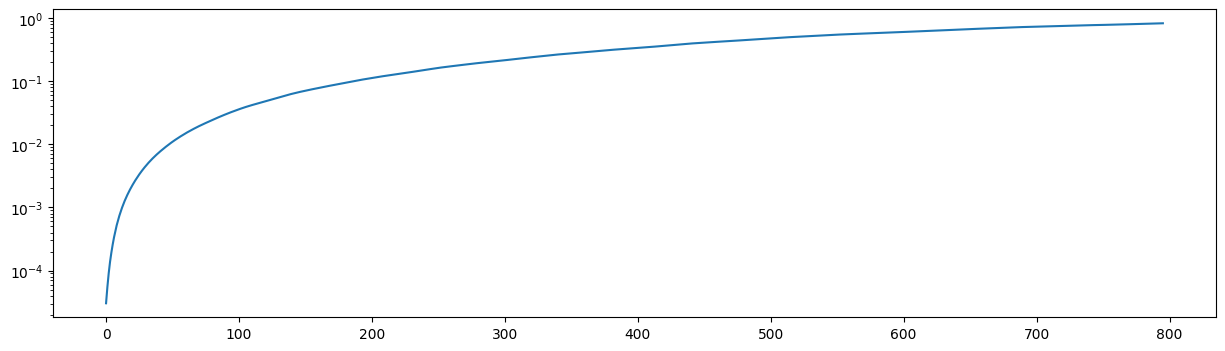

In [57]:
import matplotlib.pyplot as plt
plt.figure(figsize=(15,4))
plt.plot(torch.tensor(cost_history).detach().numpy())
ax = plt.gca()


# Set x logaritmic
ax.set_yscale('log')

In [58]:
st_e = static_error(env.unwrapped.model.get_state("alpha", to_deg=True), reference_signals[0])
print("Статическая ошибка", st_e, "градуса")

Статическая ошибка 0.27157104809125093 градуса


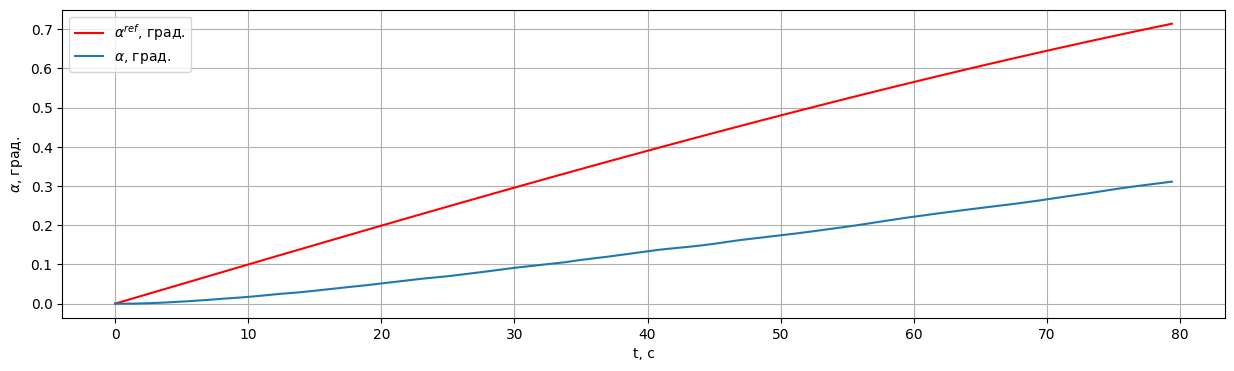

In [59]:
env.unwrapped.model.plot_transient_process('alpha', tps, reference_signals[0], to_deg=True, figsize=(15,4))

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


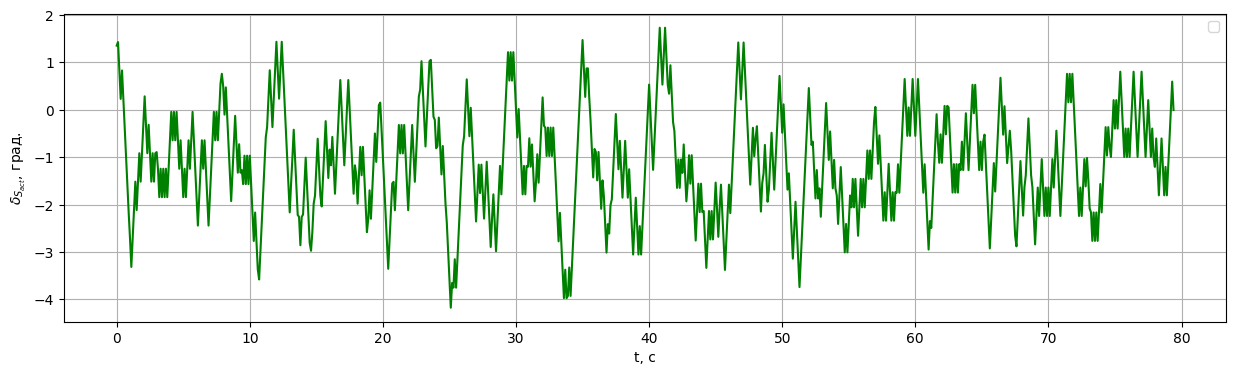

In [60]:
env.model.plot_control('ele', tps, to_deg=True, figsize=(15,4))

In [106]:
env.step(action)

(array([ 1.13003952e-02,  4.18539792e-03,  2.44010117e-03,  5.42121094e+00,
        -9.80557724e-01]),
 1,
 True,
 False,
 {})

In [81]:
# Инициализация списка для хранения исторических данных
hist = []
dt = 0.1  # Интервал дискретизации времени

# Генерация временного периода с заданным интервалом дискретизации
tp = generate_time_period(tn=80, dt=dt) 

# Конвертация временного периода в секунды
tps = convert_tp_to_sec_tp(tp, dt=dt)

# Вычисление общего количества временных шагов
number_time_steps = len(tp) 

# Создание заданного сигнала с использованием единичного шага
# reference_signals = np.reshape(unit_step(degree=0, tp=tp, time_step=20, output_rad=True), [1, -1])
reference_signals = np.reshape(np.deg2rad(sinusoid(amplitude=0.001, tp=tp, frequency=1)), [1, -1])

# Создание среды симуляции, задание временных шагов, начального состояния, заданного сигнала и отслеживаемых состояний
env = gym.make('LinearLongitudinalF16-v0',
                number_time_steps=number_time_steps, 
                initial_state=[[0],[0],[0],[0],[0]],
                reference_signal=reference_signals,
                state_space = [ "theta", "alpha", "q", "altitude", "velocity"],
                output_space = ["theta", "alpha", "q", "altitude", "velocity"],
                tracking_states=["alpha"], use_reward = False)

# Сброс среды к начальному состоянию
state, info = env.reset()
cost_history = []
action_hist = []
rollout, horizon = 1,5
for episode in range(1):
    state, info = env.reset()
    episode_reward = 0
    prev_value = torch.tensor([[0]])
    for step in tqdm(range(number_time_steps-5)):
        action, cost = choose_action_ref(state, rollout, horizon, reference_signals, step, prev_value, optimization_steps=250)
        cost_history.append(cost)
        state, reward, terminated, truncated, info= env.step(action)
        next_states.append(state)
        state = state.reshape([1, -1])[0]
        done = terminated or truncated
        episode_reward += reward
        prev_value = action
        if done:
            break
    print('rollout: %d, horizon: %d, episode: %d, reward: %d' % (rollout, horizon, episode, episode_reward))

  0%|          | 0/796 [00:00<?, ?it/s]/var/folders/kq/3y1y4twn3ls4zqd3ct3bbjz00000gp/T/ipykernel_40285/1742971041.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  action_sequence = torch.tensor(action_sequence, requires_grad=True)
100%|██████████| 796/796 [02:17<00:00,  5.80it/s]

rollout: 1, horizon: 5, episode: 0, reward: 796


In [82]:
min(torch.tensor(actions_).detach().numpy()), torch.tensor(actions_).detach().numpy()[-1]

(-0.79744893, 0.14133817)

In [83]:
min(torch.tensor(costs).detach().numpy()), torch.tensor(costs).detach().numpy()[-1]

(0.24349706, 0.4715419)

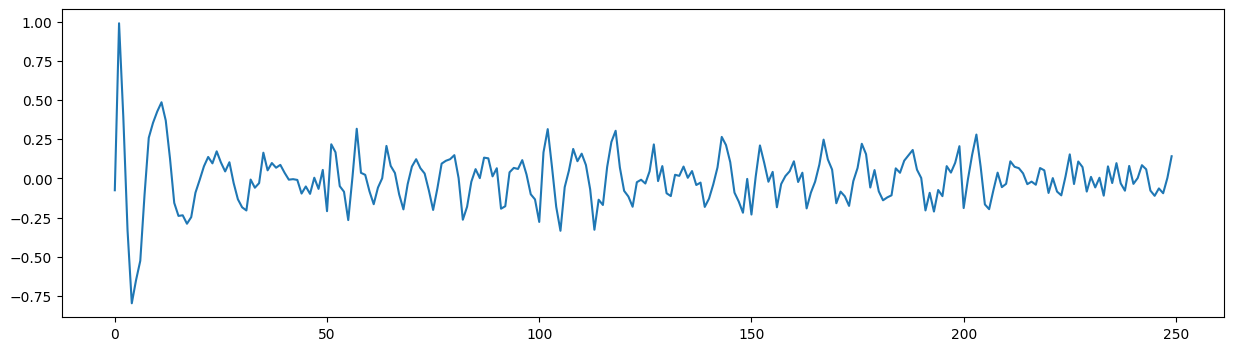

In [95]:
import matplotlib.pyplot as plt
plt.figure(figsize=(15,4))
plt.plot(torch.tensor(actions_).detach().numpy())


In [96]:
cost_history

[tensor([[0.0027]], grad_fn=<CloneBackward0>),
 tensor([[0.0063]], grad_fn=<CloneBackward0>),
 tensor([[0.0041]], grad_fn=<CloneBackward0>),
 tensor([[0.0044]], grad_fn=<CloneBackward0>),
 tensor([[0.0016]], grad_fn=<CloneBackward0>),
 tensor([[0.0014]], grad_fn=<CloneBackward0>),
 tensor([[0.0038]], grad_fn=<CloneBackward0>),
 tensor([[0.0049]], grad_fn=<CloneBackward0>),
 tensor([[0.0024]], grad_fn=<CloneBackward0>),
 tensor([[0.0022]], grad_fn=<CloneBackward0>),
 tensor([[0.0054]], grad_fn=<CloneBackward0>),
 tensor([[0.0039]], grad_fn=<CloneBackward0>),
 tensor([[0.0026]], grad_fn=<CloneBackward0>),
 tensor([[0.0024]], grad_fn=<CloneBackward0>),
 tensor([[0.0034]], grad_fn=<CloneBackward0>),
 tensor([[0.0039]], grad_fn=<CloneBackward0>),
 tensor([[0.0032]], grad_fn=<CloneBackward0>),
 tensor([[0.0029]], grad_fn=<CloneBackward0>),
 tensor([[0.0021]], grad_fn=<CloneBackward0>),
 tensor([[0.0037]], grad_fn=<CloneBackward0>),
 tensor([[0.0023]], grad_fn=<CloneBackward0>),
 tensor([[0.0

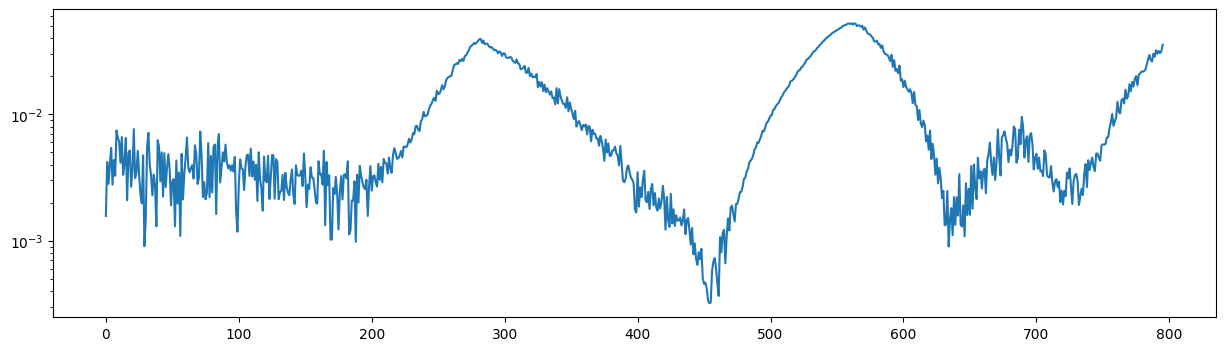

In [114]:
import matplotlib.pyplot as plt
plt.figure(figsize=(15,4))
plt.plot(torch.tensor(cost_history).detach().numpy())
ax = plt.gca()


# Set x logaritmic
ax.set_yscale('log')


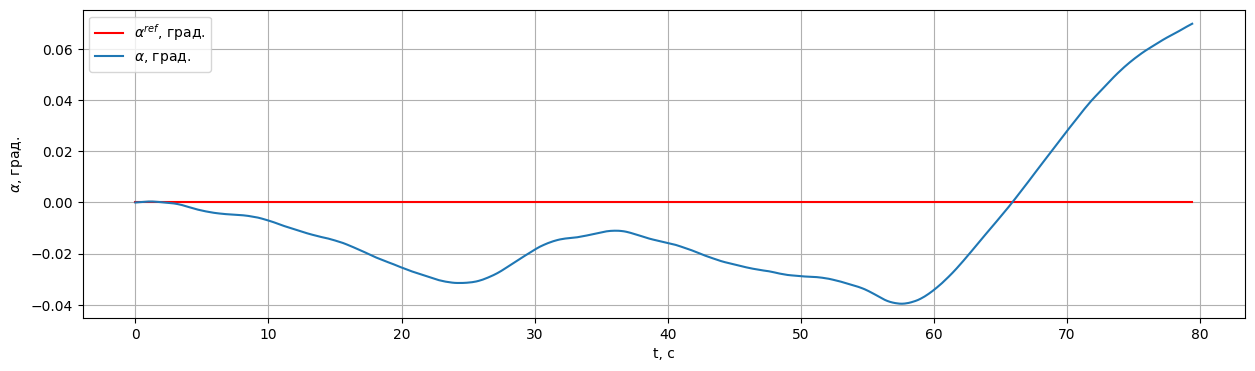

In [115]:
env.unwrapped.model.plot_transient_process('alpha', tps, reference_signals[0], to_deg=True, figsize=(15,4))

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


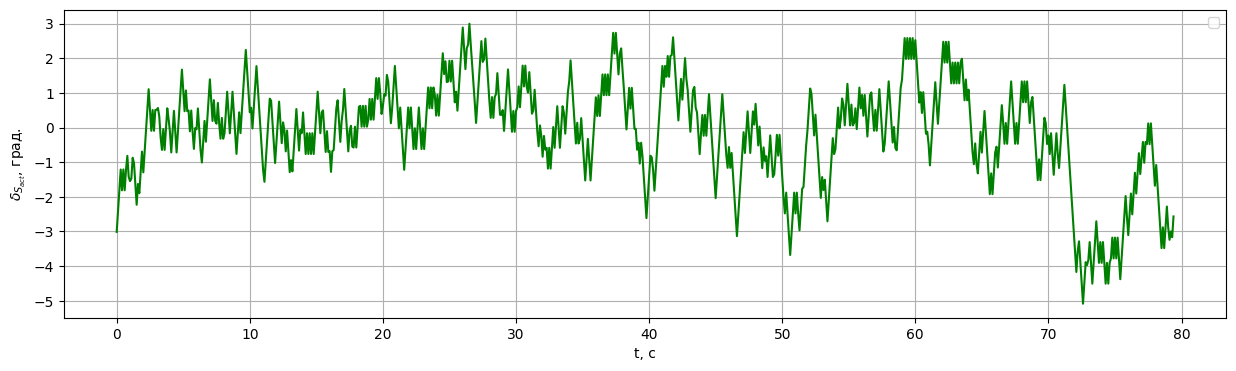

In [108]:
env.model.plot_control('ele', tps, to_deg=True, figsize=(15,4))

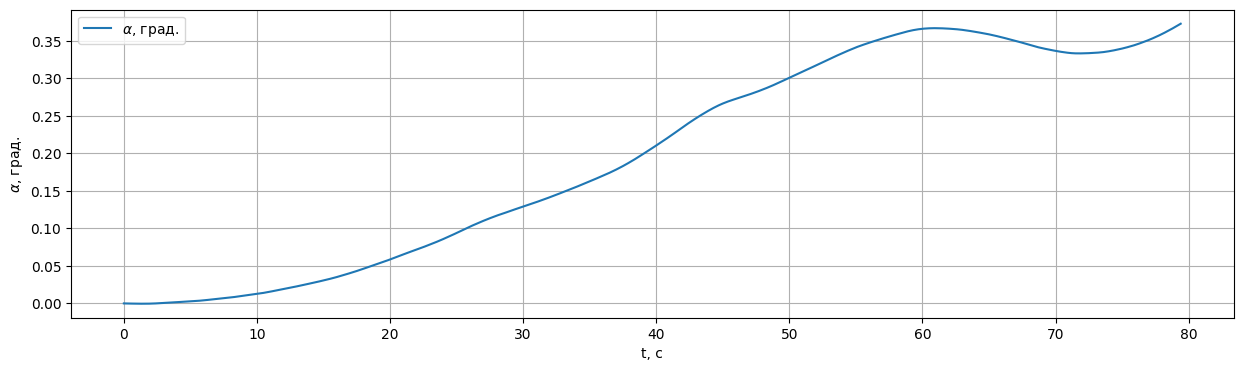

In [101]:
env.unwrapped.model.plot_state('alpha', tps, figsize=(15,4), to_deg=True)

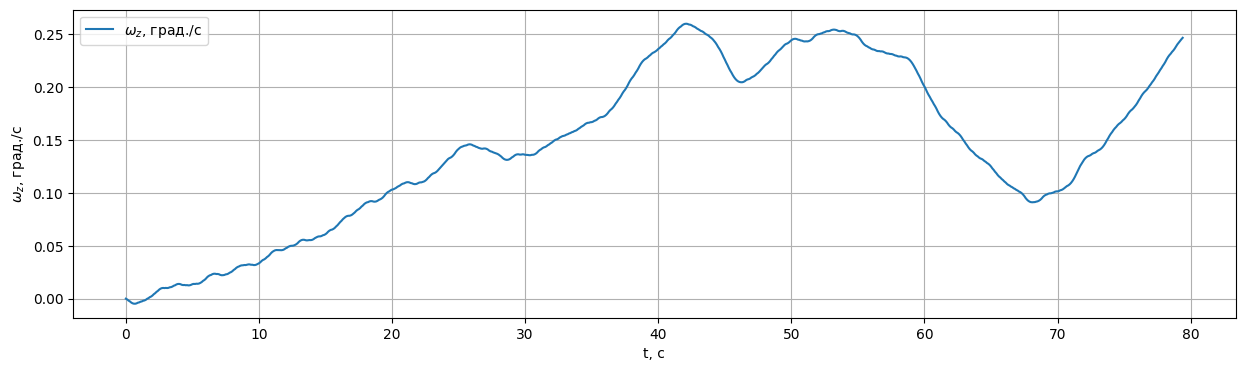

In [102]:
env.unwrapped.model.plot_state('q', tps, figsize=(15,4), to_deg=True)

In [116]:
st_e = static_error(reference_signals[0],env.unwrapped.model.get_state("alpha", to_deg=True))
print("Статическая ошибка", st_e, "градуса")

Статическая ошибка -0.05557850293817803 градуса


In [538]:
# Сохраняем агента
agent.save()

/Users/asmazaev/Projects/TensorAeroSpace/.venv/lib/python3.11/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.ref_signal to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.ref_signal` for environment variables or `env.get_wrapper_attr('ref_signal')` that will search the reminding wrappers.
  logger.warn(
